In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 46kB/s 
ERROR: Operation cancelled by user


In [1]:
import tensorflow as tf 

In [ ]:
import sys
print(sys.path)

In [2]:
print(tf.__version__)

2.3.1


In [3]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import SGD, Adam 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sys, os

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map input to (-1, 1) for better training 
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 -1
print("x_train shape: ", x_train.shape)

11493376/11490434 [==============================] - 2s 0us/step
x_train shape:  (60000, 28, 28)


In [6]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [7]:
latent_dim = 100

In [8]:
#build the generator 
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation="tanh")(x)

  model = Model(i,x)
  return model


In [9]:
# build the discriminator
def build_discriminator(img_size):
  i = Input(shape=img_size,)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(i,x)
  return model

In [10]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002, 0.5),
    metrics=["accuracy"]
)

generator = build_generator(latent_dim)

z = Input(shape=(latent_dim,))
img = generator(z)

# freeze the layers of the discriminator
discriminator.trainable = False
fake_pred = discriminator(img)

# Create combined model 
combined_model = Model(z, fake_pred)

combined_model.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

In [11]:
# /////// Train the GAN /////////

# Config 

batch_size = 32 
epochs = 30000
sample_period = 200

# Create batch labels to use when calling train_on_batch 
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images 
if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [12]:
# Function to create a grid of random samples from the generator 
# and save them to a file 

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W))
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [13]:
# main training loop 

for epoch in range(epochs):

  #### Train discriminator ####

  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # Generate fake images 
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # Train the discriminator, both loss and accuracy are returned 
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  #### Train the generator ####
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # Save the losses 
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.82,       d_acc: 0.36, g_loss: 0.69
epoch: 101/30000, d_loss: 0.01,       d_acc: 1.00, g_loss: 4.64
epoch: 201/30000, d_loss: 0.03,       d_acc: 1.00, g_loss: 4.94
epoch: 301/30000, d_loss: 0.11,       d_acc: 0.98, g_loss: 4.15
epoch: 401/30000, d_loss: 0.30,       d_acc: 0.86, g_loss: 2.66
epoch: 501/30000, d_loss: 0.82,       d_acc: 0.30, g_loss: 0.70
epoch: 601/30000, d_loss: 0.65,       d_acc: 0.53, g_loss: 0.74
epoch: 701/30000, d_loss: 0.60,       d_acc: 0.69, g_loss: 0.82
epoch: 801/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.82
epoch: 901/30000, d_loss: 0.57,       d_acc: 0.73, g_loss: 0.84
epoch: 1001/30000, d_loss: 0.63,       d_acc: 0.66, g_loss: 0.84
epoch: 1101/30000, d_loss: 0.62,       d_acc: 0.66, g_loss: 0.89
epoch: 1201/30000, d_loss: 0.58,       d_acc: 0.80, g_loss: 0.94
epoch: 1301/30000, d_loss: 0.60,       d_acc: 0.69, g_loss: 0.94
epoch: 1401/30000, d_loss: 0.56,       d_acc: 0.81, g_loss: 1.01
epoch: 1501/30000, d_loss: 0.54,     

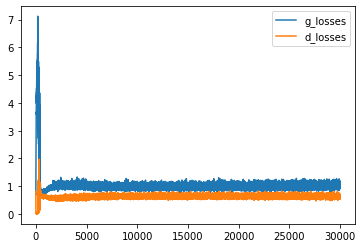

In [ ]:
plt.plot(g_losses, label="g_losses")
plt.plot(d_losses, label="d_losses")
plt.legend()

In [15]:
!ls gan_images

0.png     13200.png 16600.png 2000.png  23400.png 26800.png 3400.png  6800.png
1000.png  13400.png 16800.png 20000.png 23600.png 27000.png 3600.png  7000.png
10000.png 13600.png 17000.png 20200.png 23800.png 27200.png 3800.png  7200.png
10200.png 13800.png 17200.png 20400.png 2400.png  27400.png 400.png   7400.png
10400.png 1400.png  17400.png 20600.png 24000.png 27600.png 4000.png  7600.png
10600.png 14000.png 17600.png 20800.png 24200.png 27800.png 4200.png  7800.png
10800.png 14200.png 17800.png 21000.png 24400.png 2800.png  4400.png  800.png
11000.png 14400.png 1800.png  21200.png 24600.png 28000.png 4600.png  8000.png
11200.png 14600.png 18000.png 21400.png 24800.png 28200.png 4800.png  8200.png
11400.png 14800.png 18200.png 21600.png 25000.png 28400.png 5000.png  8400.png
11600.png 15000.png 18400.png 21800.png 25200.png 28600.png 5200.png  8600.png
11800.png 15200.png 18600.png 2200.png  25400.png 28800.png 5400.png  8800.png
1200.png  15400.png 18800.png 22000.png 25600.png 290

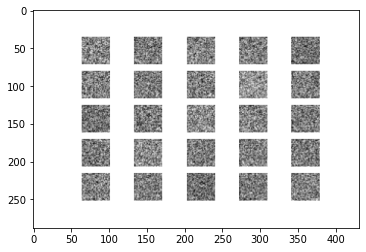

In [16]:
from skimage.io import imread 
a = imread('gan_images/0.png')
plt.imshow(a)

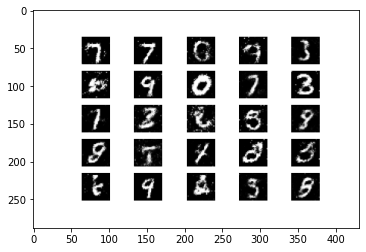

In [17]:
from skimage.io import imread 
a = imread('gan_images/10000.png')
plt.imshow(a)

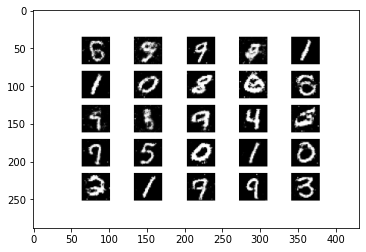

In [18]:
from skimage.io import imread 
a = imread('gan_images/20000.png')
plt.imshow(a)

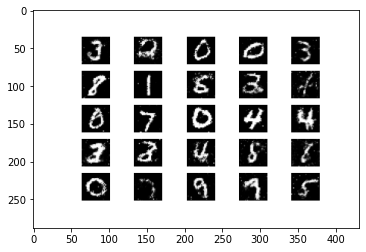

In [19]:
from skimage.io import imread 
a = imread('gan_images/29800.png')
plt.imshow(a)